# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Step 0: Load The Data

First load relevant packages

In [78]:
import pickle
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import random
import pandas as pd
from skimage import transform
from skimage.transform import warp, SimilarityTransform, AffineTransform
import cv2
import tensorflow as tf
import os
import matplotlib.image as mpimg

In [79]:
training_file = '../data/train.p'
validation_file= '../data/valid.p'
testing_file = '../data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Sanity check
assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

# Check shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (34799, 32, 32, 3)
y_train shape: (34799,)
X_valid shape: (4410, 32, 32, 3)
y_valid shape: (4410,)
X_test shape: (12630, 32, 32, 3)
y_test shape: (12630,)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [80]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# Shape of an traffic sign image
image_shape = X_train[0].shape

# Unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

# Get the list of sign names
sign_classes = pd.read_csv('signnames.csv')['SignName']

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

0. Speed limit (20km/h)


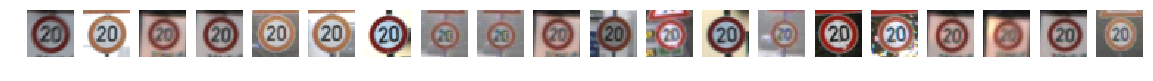

1. Speed limit (30km/h)


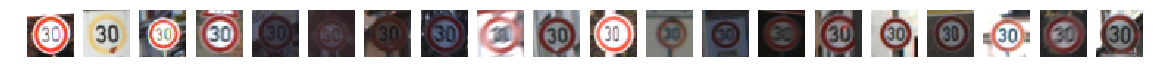

2. Speed limit (50km/h)


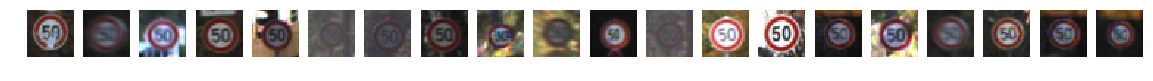

3. Speed limit (60km/h)


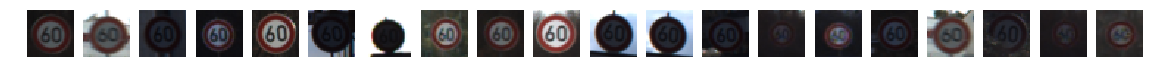

4. Speed limit (70km/h)


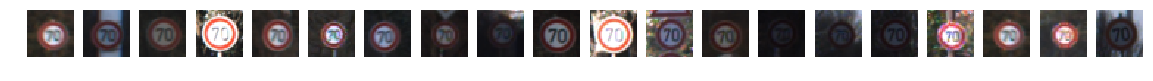

5. Speed limit (80km/h)


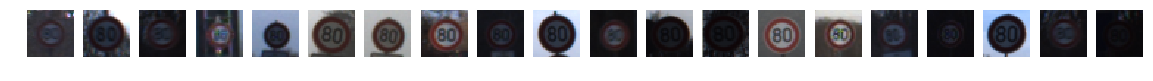

6. End of speed limit (80km/h)


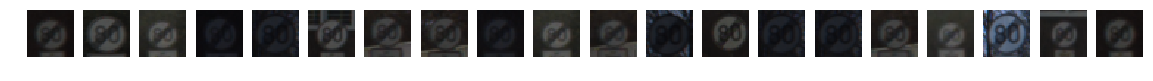

7. Speed limit (100km/h)


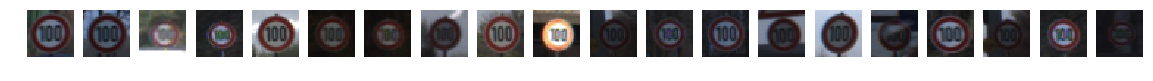

8. Speed limit (120km/h)


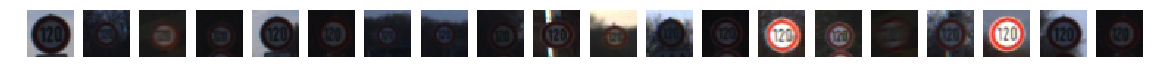

9. No passing


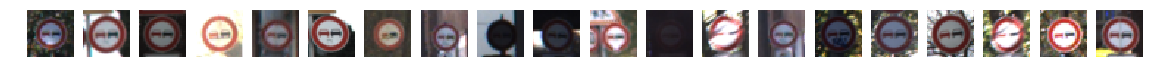

10. No passing for vehicles over 3.5 metric tons


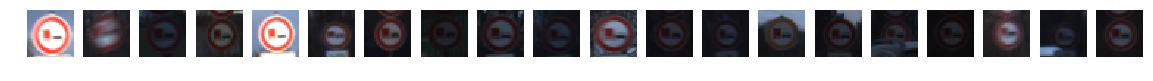

11. Right-of-way at the next intersection


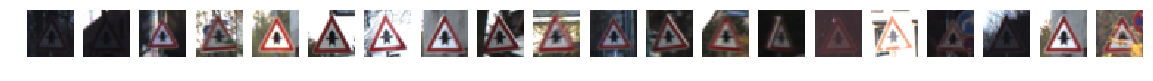

12. Priority road


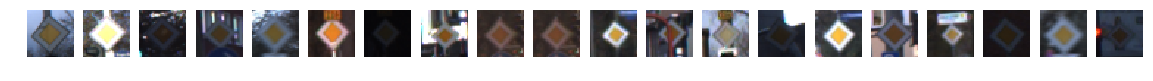

13. Yield


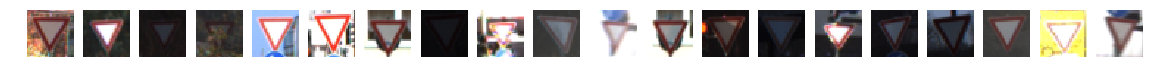

14. Stop


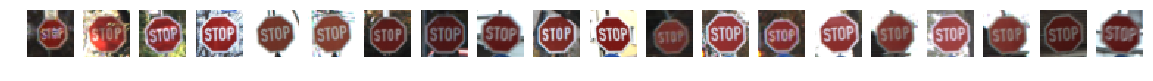

15. No vehicles


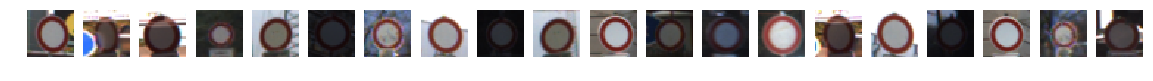

16. Vehicles over 3.5 metric tons prohibited


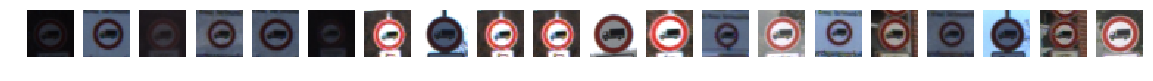

17. No entry


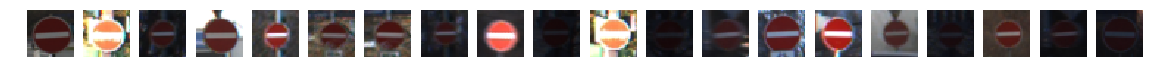

18. General caution


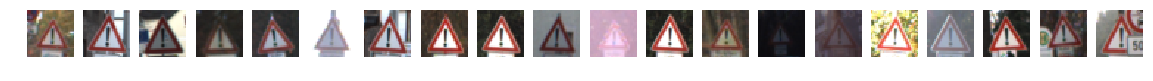

19. Dangerous curve to the left


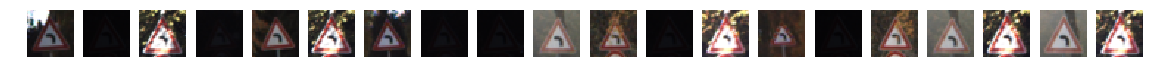

20. Dangerous curve to the right


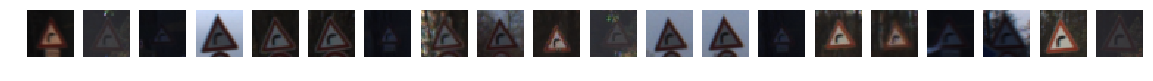

21. Double curve


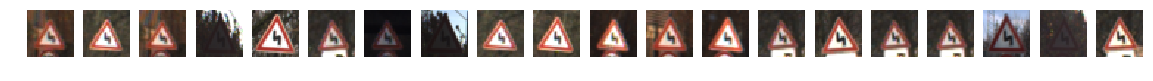

22. Bumpy road


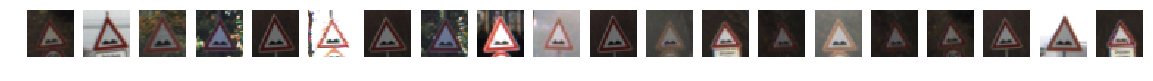

23. Slippery road


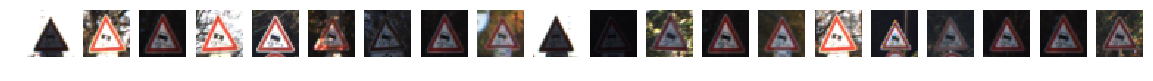

24. Road narrows on the right


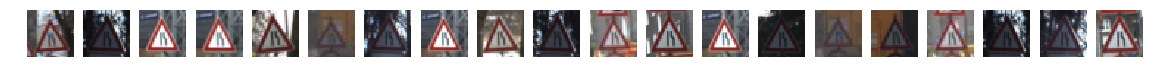

25. Road work


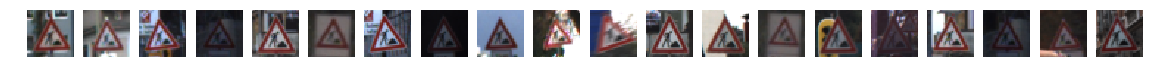

26. Traffic signals


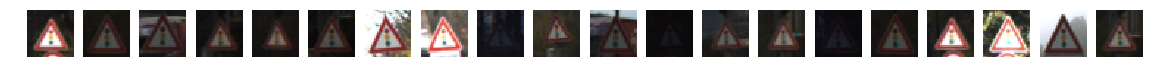

27. Pedestrians


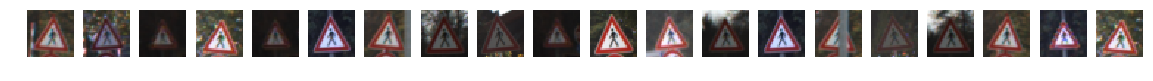

28. Children crossing


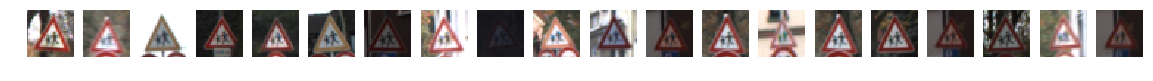

29. Bicycles crossing


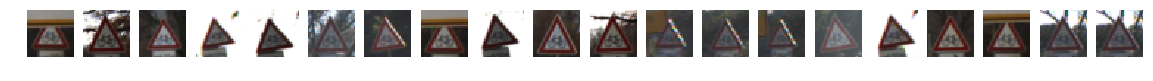

30. Beware of ice/snow


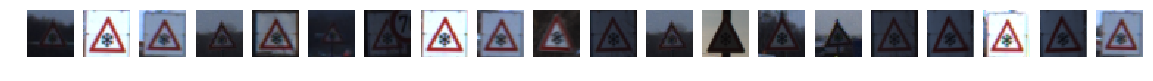

31. Wild animals crossing


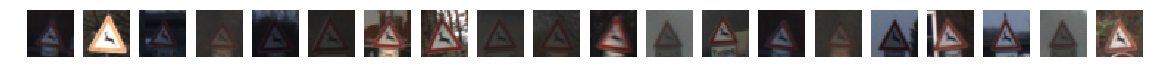

32. End of all speed and passing limits


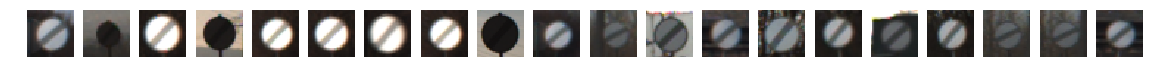

33. Turn right ahead


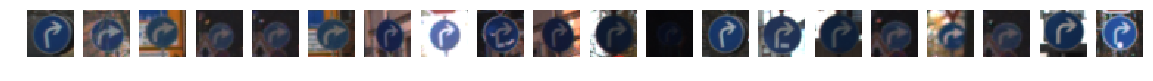

34. Turn left ahead


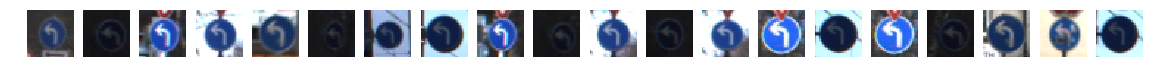

35. Ahead only


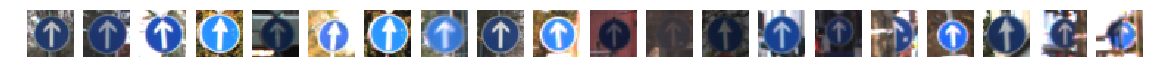

36. Go straight or right


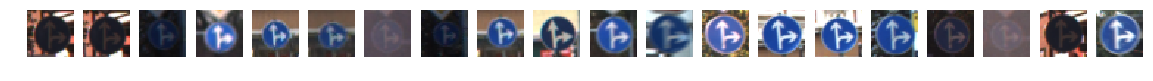

37. Go straight or left


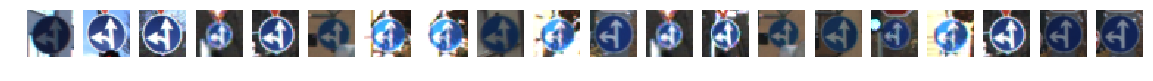

38. Keep right


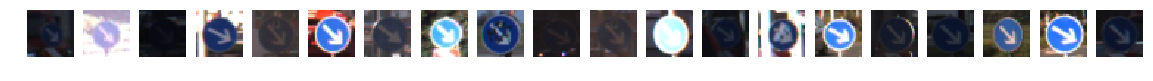

39. Keep left


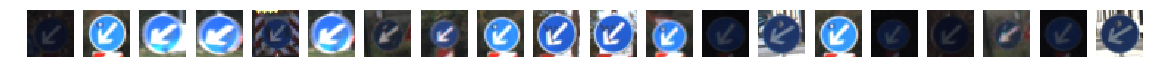

40. Roundabout mandatory


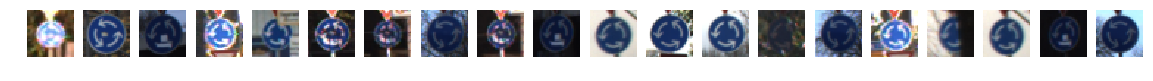

41. End of no passing


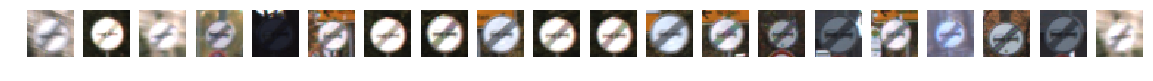

42. End of no passing by vehicles over 3.5 metric tons


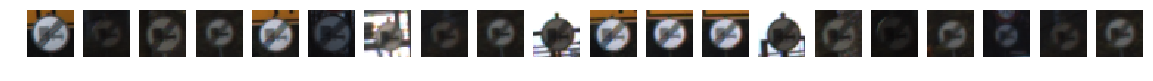

In [85]:
# Plot example images
num_imgs = 20 
for c in range(n_classes):
    idx = np.where(y_train == c)[0]
    images = X_train[np.random.choice(idx, num_imgs)]
    fig = plt.figure(figsize=(20,20))
    print(str(c) + ". " + sign_classes[c])
    for i, image in enumerate(images):
        subfig = fig.add_subplot(1, num_imgs, i + 1)
        subfig.axis('off')
        subfig.imshow(image)
    plt.show()
plt.savefig('output_images/classes.png', type="png", bbox_inches='tight')

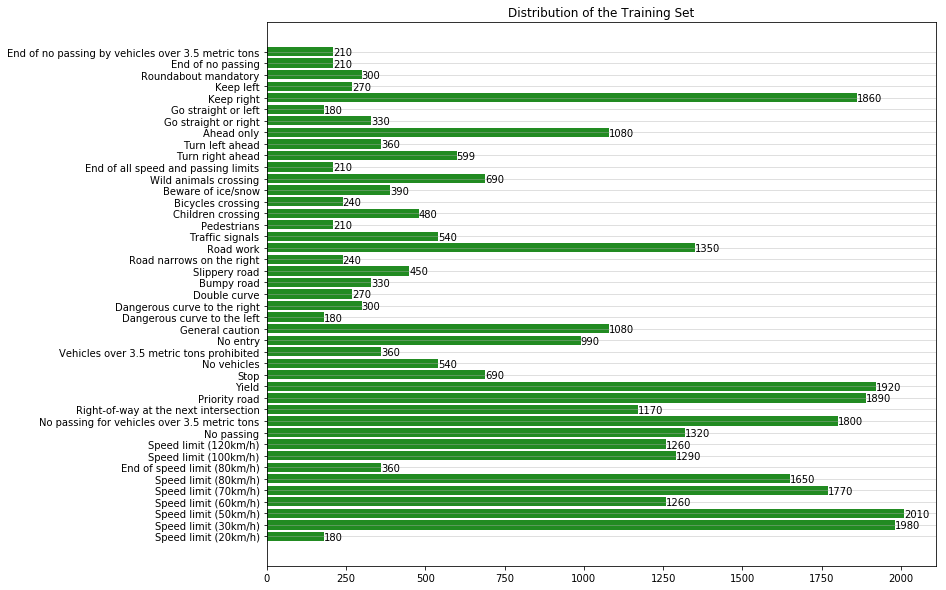

In [89]:
plt.figure(figsize=(12,10))
bins_val, _, _ = plt.hist(y_train, bins=np.arange(44)-0.5, histtype='bar', orientation="horizontal", rwidth=0.8, color='#228B22')
y_pos = np.arange(43)
plt.yticks(y_pos, sign_classes)
for i in y_pos:
    plt.text(x = bins_val[i] , y = y_pos[i]-0.3, s = bins_val[i].astype(int), size = 10)
plt.grid(axis='y', alpha=0.5)
plt.title("Distribution of the Training Set")
plt.savefig('output_images/dist_training.png', type="png", bbox_inches='tight')
plt.show()

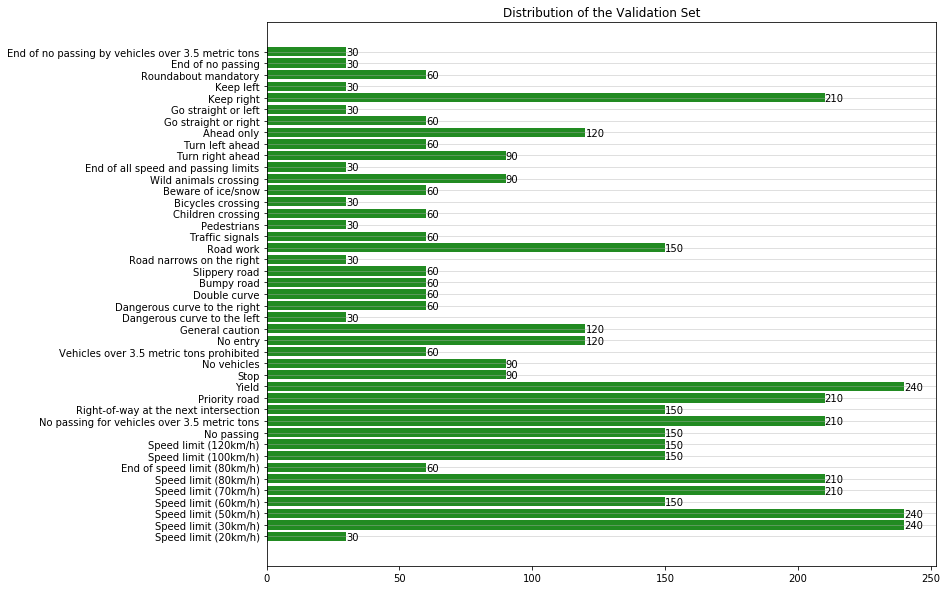

In [90]:
plt.figure(figsize=(12,10))
bins_val, _, _ = plt.hist(y_valid, bins=np.arange(44)-0.5, histtype='bar', orientation="horizontal", rwidth=0.8, color='#228B22')
y_pos = np.arange(43)
plt.yticks(y_pos, sign_classes)
for i in y_pos:
    plt.text(x = bins_val[i] , y = y_pos[i]-0.3, s = bins_val[i].astype(int), size = 10)
plt.grid(axis='y', alpha=0.5)
plt.title("Distribution of the Validation Set")
plt.savefig('output_images/dist_valid.png', type="png", bbox_inches='tight')
plt.show()

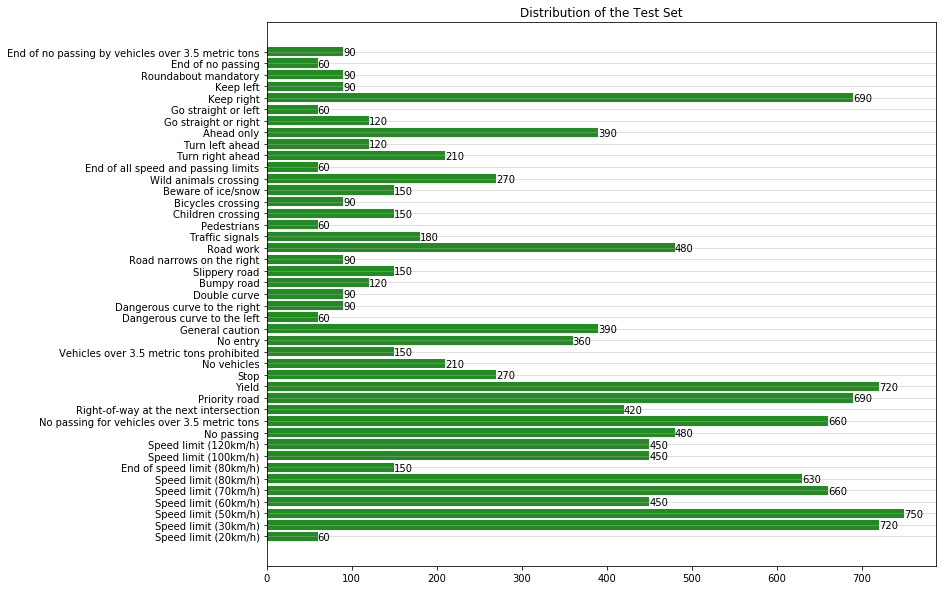

In [91]:
plt.figure(figsize=(12,10))
bins_val, _, _ = plt.hist(y_test, bins=np.arange(44)-0.5, histtype='bar', orientation="horizontal", rwidth=0.8, color='#228B22')
y_pos = np.arange(43)
plt.yticks(y_pos, sign_classes)
for i in y_pos:
    plt.text(x = bins_val[i] , y = y_pos[i]-0.3, s = bins_val[i].astype(int), size = 10)
plt.grid(axis='y', alpha=0.5)
plt.title("Distribution of the Test Set")
plt.savefig('output_images/dist_test.png', type="png", bbox_inches='tight')
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Dataset Augmentation

Data augmentation is a powerful technique to improve the performance machine learning model. There [multiple transformations](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced) for augmenting image-based datasets.

The following functions implement multiple transformations selected in this project to augment the initial dataset. Some of these functions are adapted from [here](https://github.com/sharathsrini/Traffic-Sign-Classifier/blob/master/Traffic_Sign_Classifier_Final.ipynb). The image transformations considered in this project are the following:

#### 1. Brightness Increase/Decrease

In [92]:
# Randomly increases or decreases the brightness by a factor between 0.2 and 2
def brightness(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV) #convert to hsv
    hsv = np.array(hsv, dtype=np.float64)
    factor = np.random.uniform(0.15, 2.15)
    hsv[:, :, 2] = hsv[:, :, 2] * factor #scale channel V uniformly
    hsv[:, :, 2][hsv[:, :, 2] > 255] = 255 #reset out of range values
    result = cv2.cvtColor(np.array(hsv, dtype=np.uint8), cv2.COLOR_HSV2RGB)
    return result

#### 2. Rotate

In [93]:
# Rotates the images between -angle and angle. The default absolute angle value is 15
def rotate(image, angle = 20):
    result = 255 * transform.rotate(image, angle=np.random.uniform(-angle, angle), mode='edge')
    result = result.astype(np.uint8)
    return result

#### 3. Affine Transform

In [94]:
def affine_transform(image):
    result = 255 * warp(image, transform.AffineTransform(scale=(np.random.uniform(0.8, 1.2),np.random.uniform(0.8, 1.8)),
                                                         shear=np.random.uniform(-0.2, 0.2)), mode='edge')
    result = result.astype(np.uint8)
    return result

#### 4. Translation

In [95]:
# Move the image in the x and y coordinates by a given offset. By default this offset is 10
def translation(image, offset=10):
    result = 255 * warp(image, transform.SimilarityTransform(translation=(np.random.uniform(-offset, offset),
                                                                          np.random.uniform(-offset, offset))), mode='edge')
    result = result.astype(np.uint8)
    return result

#### 5. Test image to show the various transformations

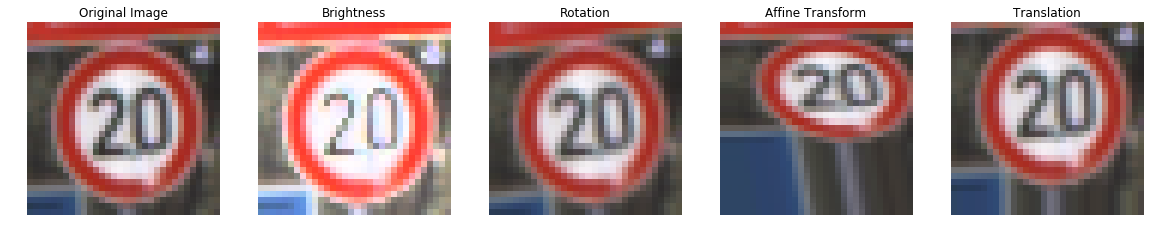

In [96]:
test_image = X_train[10100]
brightness_test = brightness(test_image)
rotation_test = rotate(test_image)
affine_transform_test = affine_transform(test_image)
translation_test = translation(test_image)

fig = plt.figure(figsize=(20,20))
subfig = fig.add_subplot(1, 5, 1)
subfig.axis('off')
subfig.set_title('Original Image')
subfig.imshow(test_image)
subfig = fig.add_subplot(1, 5, 2)
subfig.axis('off')
subfig.set_title('Brightness')
subfig.imshow(brightness_test)
subfig = fig.add_subplot(1, 5, 3)
subfig.axis('off')
subfig.set_title('Rotation')
subfig.imshow(rotation_test)
subfig = fig.add_subplot(1, 5, 4)
subfig.axis('off')
subfig.set_title('Affine Transform')
subfig.imshow(affine_transform_test)
subfig = fig.add_subplot(1, 5, 5)
subfig.axis('off')
subfig.set_title('Translation')
subfig.imshow(translation_test)
plt.savefig('output_images/transformations.png', type="png", bbox_inches='tight')

#### 6. Augment the Dataset

The function `transform_image` apply brightness transformation and in addition rotation, affine transform and/or translation are randomly applied

In [97]:
# Randomly apply at least brightness transformation, and
# possibly also rotation, affine transform and/or translation 
def transform_image(image):
    # At least brightness transformation is apply
    result = brightness(image)

    # Rotation
    apply_rotation = random.choice([True, False])
    if apply_rotation == True:
        result = rotate(result)
    
    # Affine Transform
    apply_affine_transform = random.choice([True, False])
    if apply_affine_transform == True:
        result = affine_transform(result)
        
    # Translation
    apply_translation = random.choice([True, False])
    if apply_translation == True:
        result = translation(result)
    
    return result
        
def augment_dataset(X_train, y_train, n_augment = 1000):
    for n_class in range(n_classes):
        idx = np.where(y_train == n_class)[0]
        augmented_images = []
        
        for i in range(n_augment):
            image = X_train[np.random.choice(idx)]
            result = transform_image(image)
            augmented_images.append(result)
            
        X_train = np.concatenate((X_train, augmented_images), axis=0)
        y_train = np.concatenate((y_train, [n_class] * n_augment), axis=0)
        
    return X_train, y_train

Augmented X_train shape: (77799, 32, 32, 3)
Augmented y_train shape: (77799,)


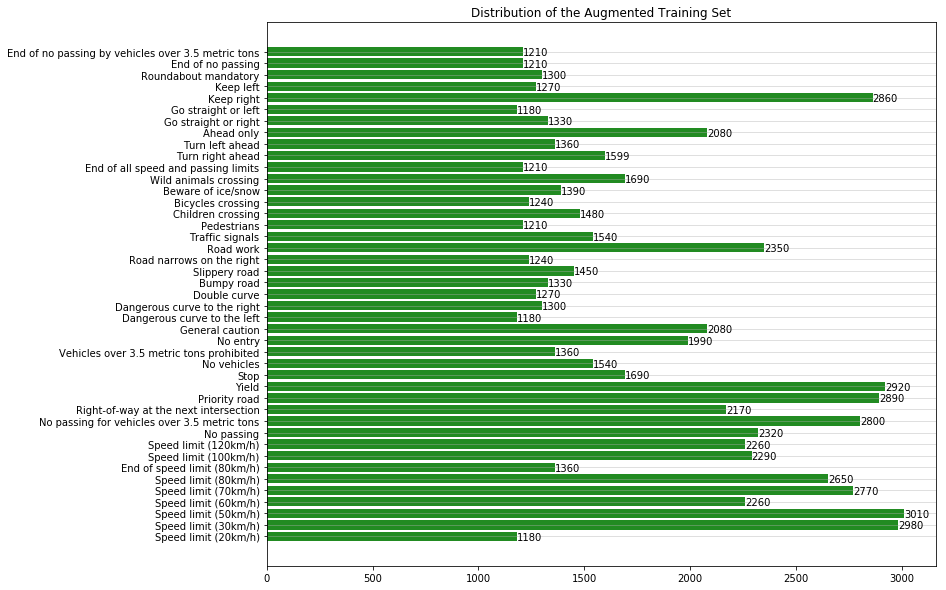

In [98]:
# Augment the dataset
X_train, y_train = augment_dataset(X_train, y_train)
print("Augmented X_train shape: " + str(X_train.shape))
print("Augmented y_train shape: " + str(y_train.shape))

# Show the new distribution of the training set
plt.figure(figsize=(12,10))
bins_val, _, _ = plt.hist(y_train, bins=np.arange(44)-0.5, histtype='bar', orientation="horizontal", rwidth=0.8, color='#228B22')
y_pos = np.arange(43)
plt.yticks(y_pos, sign_classes)
for i in y_pos:
    plt.text(x = bins_val[i] , y = y_pos[i]-0.3, s = bins_val[i].astype(int), size = 10)
plt.grid(axis='y', alpha=0.5)
plt.title("Distribution of the Augmented Training Set")
plt.savefig('output_images/dist_training_augmented.png', type="png", bbox_inches='tight')
plt.show()

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

##### 1. Converting to Grayscale

In [99]:
def grayscale_img(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def grayscale(images):
    return np.array([np.expand_dims(grayscale_img(image), axis=2) for image in images])

In [100]:
# Convert to grayscale
X_train = grayscale(X_train)
X_valid = grayscale(X_valid)
X_test = grayscale(X_test)

# Check the new shapes
print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)
print("X_test shape:", X_test.shape)

X_train shape: (77799, 32, 32, 1)
X_valid shape: (4410, 32, 32, 1)
X_test shape: (12630, 32, 32, 1)


##### 2. Improve Contrast

In [101]:
def contrast_img(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
    return clahe.apply(image)

def contrast(images):
    return np.array([np.expand_dims(contrast_img(image), axis=2) for image in images])

In [102]:
# Apply contrast improvement
X_train = contrast(X_train)
X_valid = contrast(X_valid)
X_test = contrast(X_test)

##### 3. Normalizing images

In [103]:
def normalize_img(image):
    min_val, max_val = np.min(image), np.max(image)
    return (image - min_val) / (max_val - min_val) * 2 - 1

def normalize(images):
    return np.array([normalize_img(image) for image in images])

In [104]:
# Check the mean before normalization
print("Mean values before normalization:")
print("X_train = {}".format(np.mean(X_train)))
print("X_valid = {}".format(np.mean(X_valid)))
print("X_test = {}\n".format(np.mean(X_test)))

X_train = normalize(X_train)
X_valid = normalize(X_valid)
X_test = normalize(X_test)

print("Mean values after normalization:")
print("X_train = {}".format(np.mean(X_train)))
print("X_valid = {}".format(np.mean(X_valid)))
print("X_test = {}\n".format(np.mean(X_test)))

Mean values before normalization:
X_train = 99.7577245454834
X_valid = 100.90490628543084
X_test = 100.97316633573337

Mean values after normalization:
X_train = -0.20362353559102458
X_valid = -0.19833873675568914
X_test = -0.20924525446180167



#### 4. Showing Image Examples

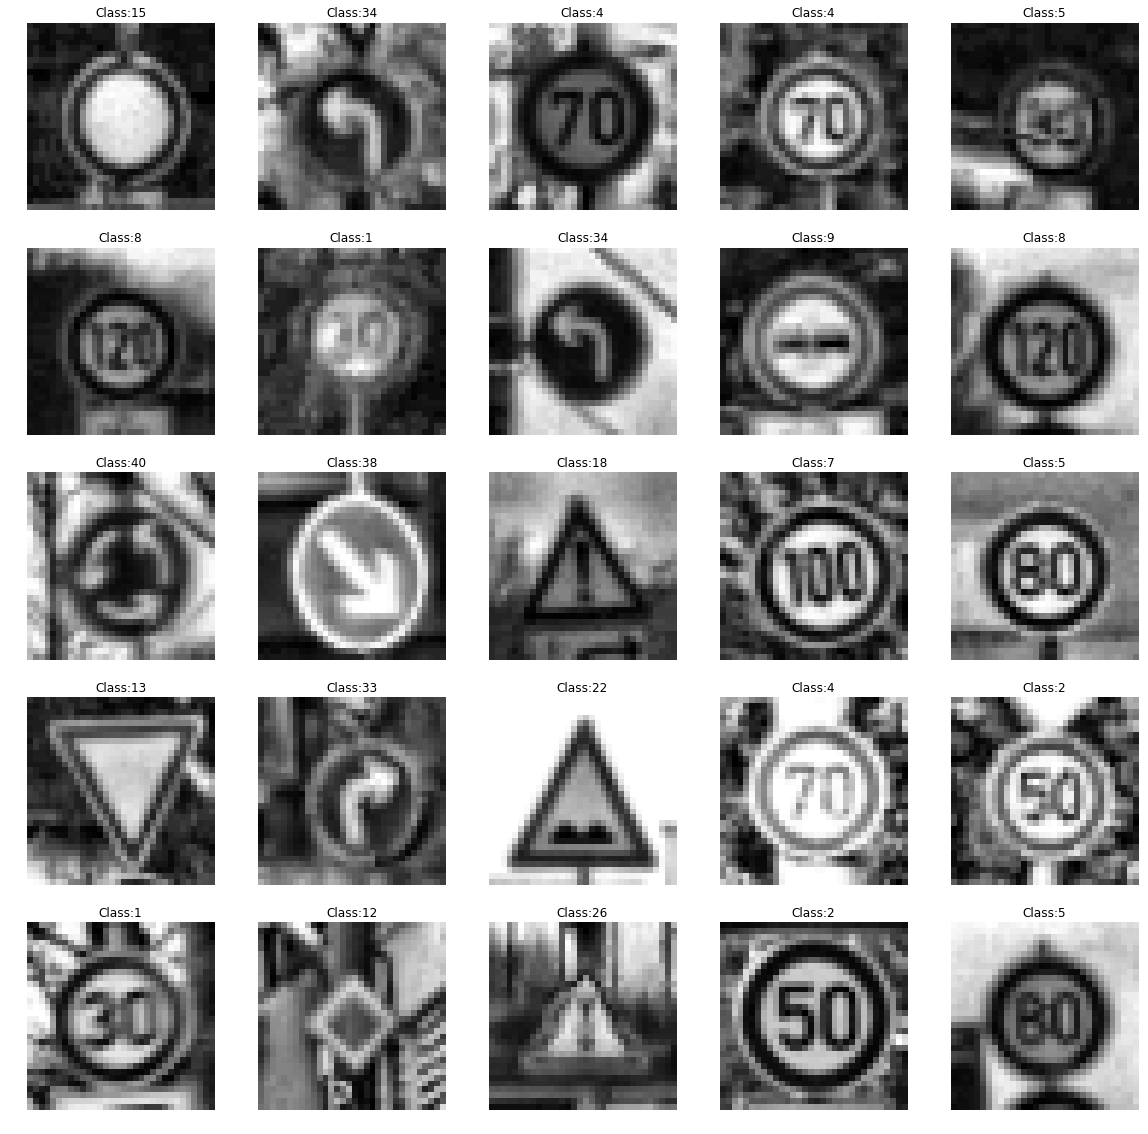

In [105]:
# Show 25 random images to check grayscale
fig = plt.figure(figsize=(20,20))
for i in range(25):
    idx = random.randint(0, n_train)
    image = X_train[idx].squeeze()
    subfig = fig.add_subplot(5, 5, i + 1)
    subfig.axis('off')
    subfig.set_title('Class:' + str(y_train[idx]))
    subfig.imshow(image, cmap='gray')
plt.savefig('output_images/preprocessed.png', type="png", bbox_inches='tight')

##### 3. Shuffle data

In [39]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

### Model Architecture: LetNet-5 - Traditional Architecture

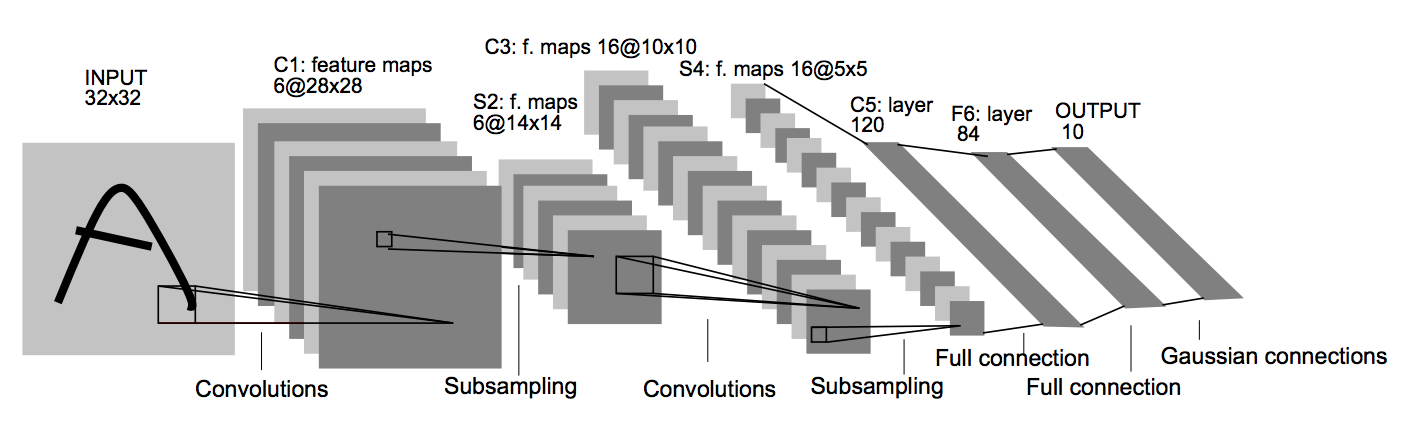

The first architecture implemented in this project is the LetNet-5 proposed by Y. LeCunn et al. in the paper ["Gradient-based learning applied to document recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) in 1998. This is the traditional ConvNet architecture used as a reference during the lessons 14 y 15 of the Self-Driving Engineer Nanodegree of Udacity. 

In [9]:
# General parameters 
EPOCHS = 80
BATCH_SIZE = 128

In [23]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    print("Traditional Architecture")

    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    print("conv1:",conv1.get_shape())

    # Activation.
    conv1 = tf.nn.relu(conv1)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    sub1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    print("sub1:",sub1.get_shape())

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(sub1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    print("conv2:",conv2.get_shape())
  
    # Activation.
    conv2 = tf.nn.relu(conv2)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    sub2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    print("sub2:",sub2.get_shape())

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(sub2)
    print("fc0:",fc0.get_shape())

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    print("fc1:",fc1.get_shape())
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2   = tf.matmul(fc1, fc2_W) + fc2_b
    print("fc2:",fc2.get_shape())
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    print("logits:",logits.get_shape())
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [24]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

# Features and labels
x = tf.placeholder(tf.float32, (None, 32, 32, 1), name = "x")
y = tf.placeholder(tf.int32, (None), name = "y")
keep_prob = tf.placeholder(tf.float32, name = "keep_prob")
one_hot_y = tf.one_hot(y, 43)

##### 1. Training Pipeline

In [25]:
rate = 0.0009

logits1 = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits1)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Traditional Architecture
conv1: (?, 28, 28, 6)
sub1: (?, 14, 14, 6)
conv2: (?, 10, 10, 16)
sub2: (?, 5, 5, 16)
fc0: (?, 400)
fc1: (?, 120)
fc2: (?, 84)
logits: (?, 43)


##### 2. Model Evaluation

In [26]:
correct_prediction1 = tf.equal(tf.argmax(logits1, 1), tf.argmax(one_hot_y, 1))
accuracy_operation1 = tf.reduce_mean(tf.cast(correct_prediction1, tf.float32), name="accuracy_operation")
saver = tf.train.Saver()

def evaluate1(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation1, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

##### 3. Train the Model

In [27]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    validation_accuracy_graph_1 = []

    print("Training Traditional Architecture...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate1(X_valid, y_valid)
        validation_accuracy_graph_1.append(validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet1')
    print("Model saved")

Training Traditional Architecture...

EPOCH 1 ...
Validation Accuracy = 0.805

EPOCH 2 ...
Validation Accuracy = 0.891

EPOCH 3 ...
Validation Accuracy = 0.920

EPOCH 4 ...
Validation Accuracy = 0.933

EPOCH 5 ...
Validation Accuracy = 0.932

EPOCH 6 ...
Validation Accuracy = 0.949

EPOCH 7 ...
Validation Accuracy = 0.949

EPOCH 8 ...
Validation Accuracy = 0.950

EPOCH 9 ...
Validation Accuracy = 0.949

EPOCH 10 ...
Validation Accuracy = 0.956

EPOCH 11 ...
Validation Accuracy = 0.959

EPOCH 12 ...
Validation Accuracy = 0.958

EPOCH 13 ...
Validation Accuracy = 0.966

EPOCH 14 ...
Validation Accuracy = 0.968

EPOCH 15 ...
Validation Accuracy = 0.971

EPOCH 16 ...
Validation Accuracy = 0.963

EPOCH 17 ...
Validation Accuracy = 0.968

EPOCH 18 ...
Validation Accuracy = 0.966

EPOCH 19 ...
Validation Accuracy = 0.967

EPOCH 20 ...
Validation Accuracy = 0.966

EPOCH 21 ...
Validation Accuracy = 0.967

EPOCH 22 ...
Validation Accuracy = 0.967

EPOCH 23 ...
Validation Accuracy = 0.968

EPOCH

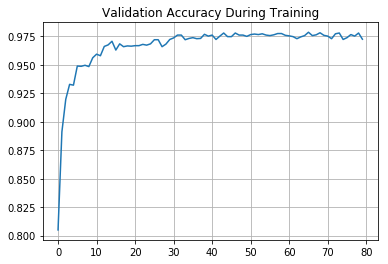

In [28]:
# Show the validation accuracy graph    
plt.plot(validation_accuracy_graph_1)
plt.title("Validation Accuracy During Training")
plt.grid()
plt.show()

##### 4. Evaluate the Test Set

In [30]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lenet1.meta')
    saver.restore(sess, "./lenet1")
    
    test_accuracy = evaluate1(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet1
Test Accuracy = 0.952


### Model Architecture: Adapted Architecture for Traffic Sign Recognition

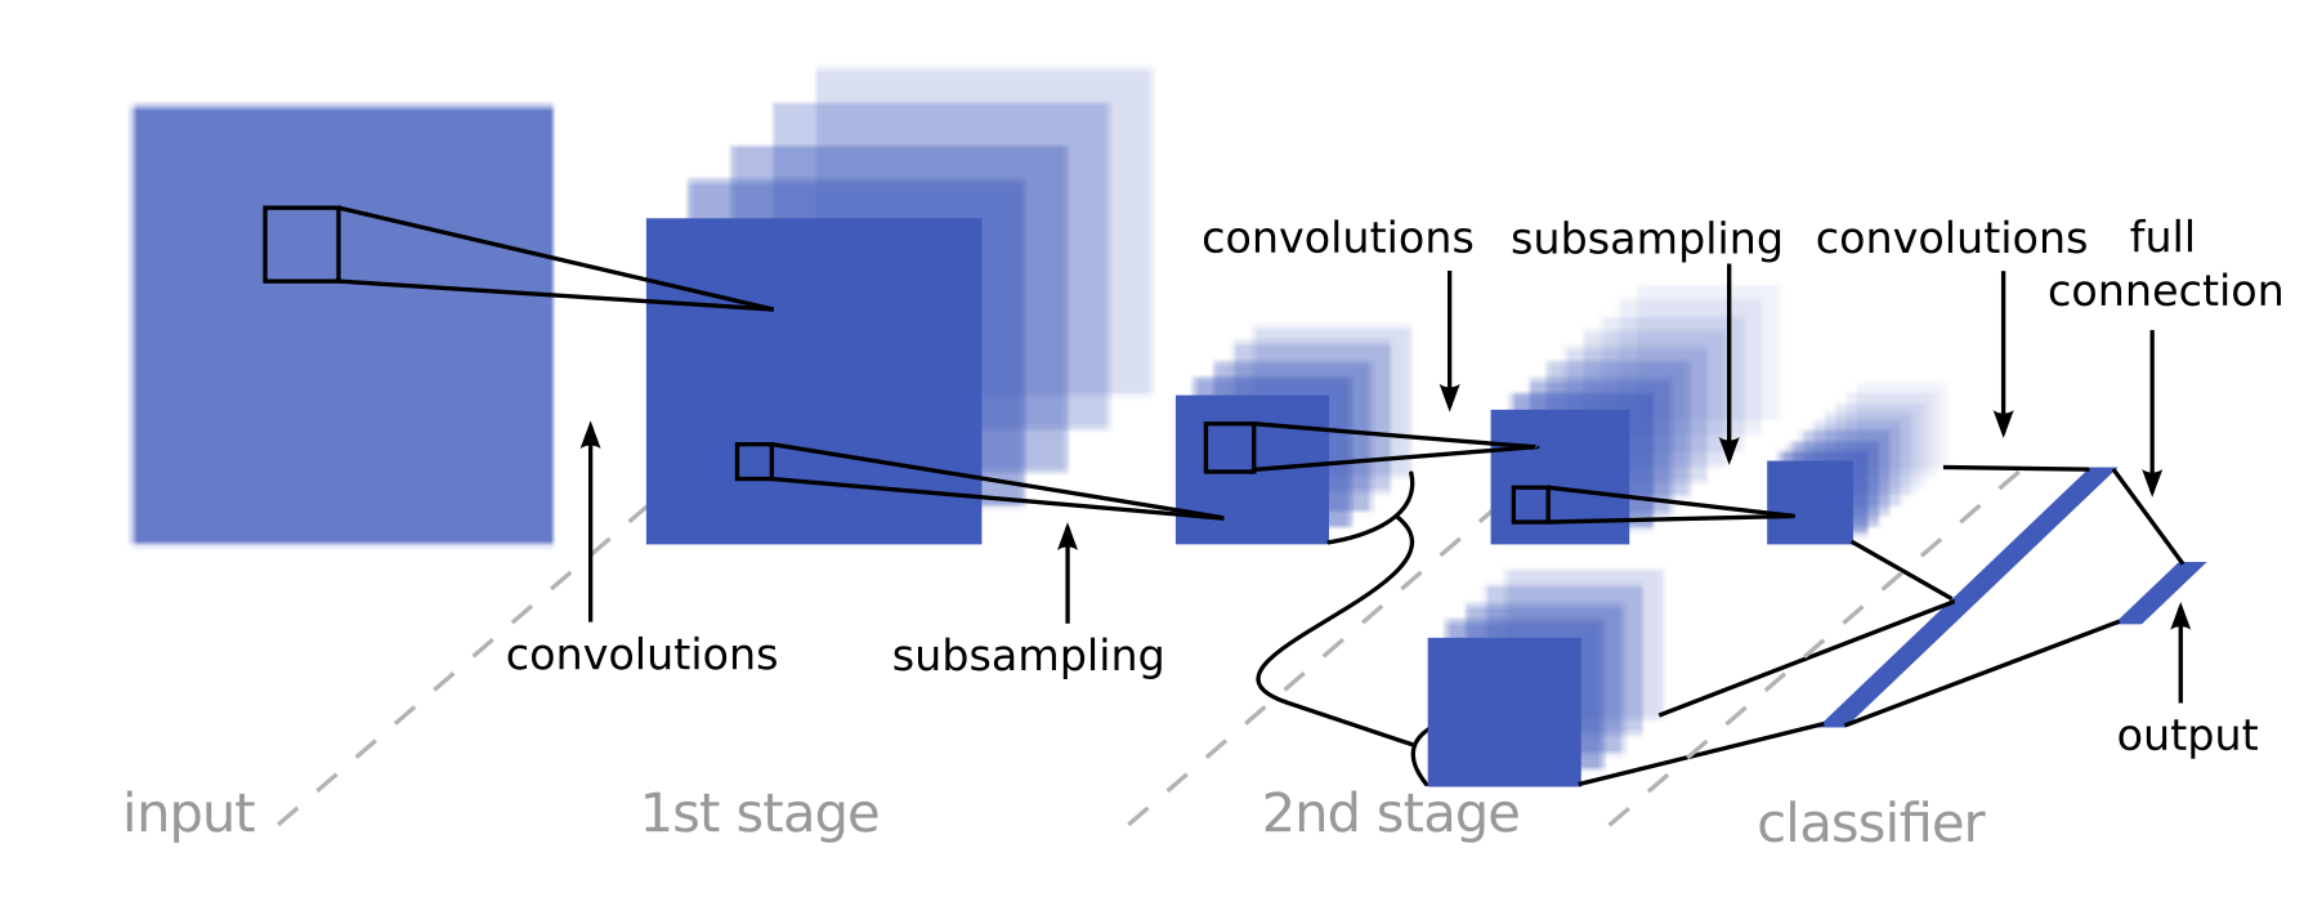

This second architecture implemented in this project is based on the one proposed by Pierre Sermanet and Yann LeCun in the paper [Traffic Sign Recognition with Multi-Scale Convolutional Networks](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) in 2011. This architecture is based on the tradicional LetNet-5 implemented and evaluated in the previous section. The key difference of the adapted architecture is that the output of the first stage is branched out and fed to the classifier, in addition to the output of the second stage.  


In [7]:
# General parameters 
EPOCHS = 80
BATCH_SIZE = 128

In [8]:
from tensorflow.contrib.layers import flatten

def LeNet2(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1

    print("Modified Architecture")

    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    print("conv1:",conv1.get_shape())

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling (Subsampling). Input = 28x28x6. Output = 14x14x6.
    sub1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    print("sub1:",sub1.get_shape())
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(sub1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    print("conv2:",conv2.get_shape())

    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling (Subsampling). Input = 10x10x16. Output = 5x5x16.
    sub2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    print("sub2:",sub2.get_shape())
    
    # Layer 3: Convolutional. Output = 1x1x400.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(400))
    conv3   = tf.nn.conv2d(sub2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    print("conv3:",conv3.get_shape())
   
    # Activation.
    conv3 = tf.nn.relu(conv3)
    
    # Flatten. 
    fc0a   = flatten(conv2) # Output = 1600.
    fc0b   = flatten(conv3) # Output = 400.
    fc0    = tf.concat([fc0a, fc0b], 1)
    print("fc0:",fc0.get_shape())

    # Dropout
    fc0 = tf.nn.dropout(fc0, keep_prob_fc)
    
    # Layer 5: Fully Connected. Input = 800. Output = 43.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(2000, 84), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(84))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    print("fc1:",fc1.get_shape())

    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Dropout
    fc1    = tf.nn.dropout(fc1, keep_prob_fc)
    
    # Layer 5: Fully Connected. Input = 100. Output = 43.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc1, fc2_W) + fc2_b
    print("logits:",logits.get_shape())
    
    return logits

### Train, Validate and Test the Model

In [9]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

# Reset the current graph
tf.reset_default_graph()

# Features and labels
x = tf.placeholder(tf.float32, (None, 32, 32, 1), name="x")
y = tf.placeholder(tf.int32, (None), name="y")
keep_prob_fc = tf.placeholder(tf.float32, name="keep_prob")
one_hot_y = tf.one_hot(y, 43)

##### 1. Training Pipeline

In [10]:
rate = 0.0009

logits2 = LeNet2(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits2)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Modified Architecture
conv1: (?, 28, 28, 6)
sub1: (?, 14, 14, 6)
conv2: (?, 10, 10, 16)
sub2: (?, 5, 5, 16)
conv3: (?, 1, 1, 400)
fc0: (?, 2000)
fc1: (?, 84)
logits: (?, 43)


##### 2. Model Evaluation

In [11]:
correct_prediction2 = tf.equal(tf.argmax(logits2, 1), tf.argmax(one_hot_y, 1), name="prediction")
accuracy_operation2 = tf.reduce_mean(tf.cast(correct_prediction2, tf.float32), name="accuracy")
saver = tf.train.Saver()

# For later evaluation
softmax = tf.nn.softmax(logits2, name="softmax")
top_k = tf.nn.top_k(softmax, k=5, name="topk5")

def evaluate2(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation2, feed_dict={x: batch_x, y: batch_y, keep_prob_fc: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

##### 3. Train the Model

In [66]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    validation_accuracy_graph_2 = []

    print("Training Adapted Architecture...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob_fc: 0.5})

        validation_accuracy = evaluate2(X_valid, y_valid)
        validation_accuracy_graph_2.append(validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet2')
    print("Model saved")

Training Adapted Architecture...

EPOCH 1 ...
Validation Accuracy = 0.902

EPOCH 2 ...
Validation Accuracy = 0.936

EPOCH 3 ...
Validation Accuracy = 0.958

EPOCH 4 ...
Validation Accuracy = 0.962

EPOCH 5 ...
Validation Accuracy = 0.970

EPOCH 6 ...
Validation Accuracy = 0.974

EPOCH 7 ...
Validation Accuracy = 0.978

EPOCH 8 ...
Validation Accuracy = 0.976

EPOCH 9 ...
Validation Accuracy = 0.976

EPOCH 10 ...
Validation Accuracy = 0.979

EPOCH 11 ...
Validation Accuracy = 0.978

EPOCH 12 ...
Validation Accuracy = 0.978

EPOCH 13 ...
Validation Accuracy = 0.976

EPOCH 14 ...
Validation Accuracy = 0.978

EPOCH 15 ...
Validation Accuracy = 0.980

EPOCH 16 ...
Validation Accuracy = 0.981

EPOCH 17 ...
Validation Accuracy = 0.979

EPOCH 18 ...
Validation Accuracy = 0.981

EPOCH 19 ...
Validation Accuracy = 0.981

EPOCH 20 ...
Validation Accuracy = 0.980

EPOCH 21 ...
Validation Accuracy = 0.981

EPOCH 22 ...
Validation Accuracy = 0.982

EPOCH 23 ...
Validation Accuracy = 0.979

EPOCH 24 

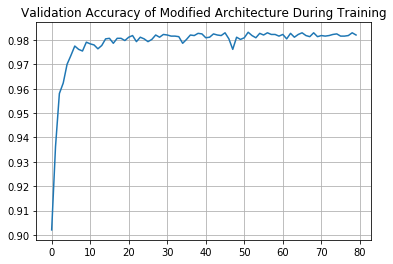

In [67]:
# Show the validation accuracy graph    
plt.plot(validation_accuracy_graph_2)
plt.title("Validation Accuracy of Modified Architecture During Training")
plt.grid()
plt.show()

In [68]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lenet2.meta')
    saver.restore(sess, "./lenet2")
    
    test_accuracy = evaluate2(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet2
Test Accuracy = 0.964


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

Since I am located in Germany I was able to take the following pictures of traffic signs myself

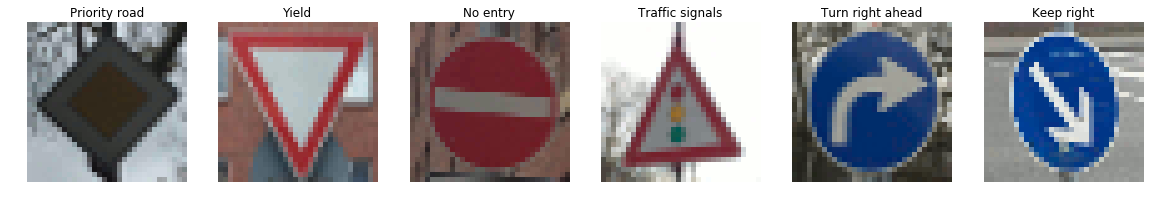

new_images shape: (6, 32, 32, 1)


In [106]:
### Load the images and plot them 
new_images_dir = "new_test_signs/"
new_images_files = os.listdir(new_images_dir)
new_images = []
new_images_class = [12, 13, 17, 26, 33, 38]
new_images_files.sort()

# Load and plot images
fig = plt.figure(figsize=(20,20))
for i, image_file in enumerate(new_images_files):
    image = cv2.imread(new_images_dir + image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    new_images.append(image)
    subfig = fig.add_subplot(1, 6, i+ 1)
    subfig.axis('off')
    subfig.set_title(sign_classes[new_images_class[i]])
    subfig.imshow(image)
plt.savefig('output_images/new_images.png', type="png", bbox_inches='tight')
plt.show()

# Preprocess images
pre_new_images = np.asarray(new_images)
pre_new_images = grayscale(pre_new_images)
pre_new_images = contrast(pre_new_images)
pre_new_images = normalize(pre_new_images)

print("new_images shape: " + str(pre_new_images.shape))

### Predict the Sign Type for Each Image

The evaluation of the new image set is based on the adapted architecture, since is the one that achived the best performance

INFO:tensorflow:Restoring parameters from ./lenet2


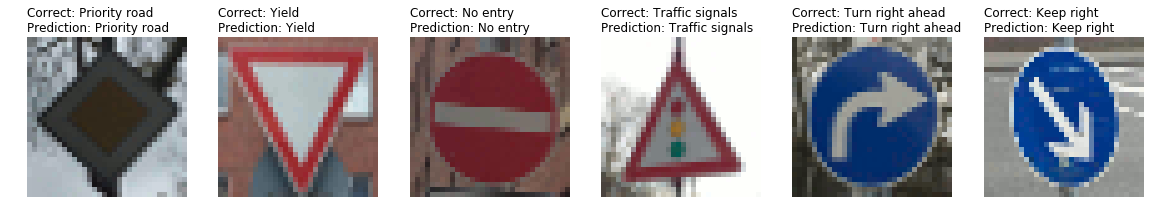

In [107]:
# Reset the current graph
tf.reset_default_graph()
graph=tf.Graph()

with graph.as_default():
    sess = tf.Session()
    with sess.as_default():
        imported_graph = tf.train.import_meta_graph('./lenet2.meta')
        imported_graph.restore(sess, "./lenet2")
        
        arg_max = graph.get_operation_by_name("ArgMax").outputs[0]
        x = graph.get_operation_by_name("x").outputs[0]
        keep_prob = graph.get_operation_by_name("keep_prob").outputs[0]

        predictions = sess.run(arg_max, feed_dict={x: pre_new_images, keep_prob: 1.0})
        
        fig = plt.figure(figsize=(20,20))

        for i, (correct_id, predict_id) in enumerate(zip(new_images_class, predictions)):
            subfig = fig.add_subplot(1, 6, i + 1)
            subfig.set_title('Correct: {:22s}\n'.format(sign_classes[correct_id]) +
                             'Prediction: {:22s}'.format(sign_classes[predict_id]), loc='left')
            subfig.axis('off')
            subfig.imshow(new_images[i])
        plt.savefig('output_images/new_images_prediction.png', type="png", bbox_inches='tight')
        plt.show()                

As can be seen, the trained model was able to correctly identify all new images

### Analyze Performance

In [14]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

# Reset the current graph
tf.reset_default_graph()

graph=tf.Graph()

with graph.as_default():
    sess = tf.Session()
    with sess.as_default():
        imported_graph = tf.train.import_meta_graph('./lenet2.meta')
        imported_graph.restore(sess, "./lenet2")
        
        # Get operations by name
        accuracy_operation = graph.get_operation_by_name("accuracy").outputs[0]
        x = graph.get_operation_by_name("x").outputs[0]
        y = graph.get_operation_by_name("y").outputs[0]
        keep_prob = graph.get_operation_by_name("keep_prob").outputs[0]
    
        num_examples = len(pre_new_images)
        total_accuracy = 0
    
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = pre_new_images[offset:offset+BATCH_SIZE], new_images_class[offset:offset+BATCH_SIZE]
            accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
            total_accuracy += (accuracy * len(batch_x))
        
        print("New Images Accuracy = {:.3f}".format(total_accuracy / num_examples))

INFO:tensorflow:Restoring parameters from ./lenet2
New Images Accuracy = 1.000


As expected from the results of the previous section, the achieved accuracy is **100%**

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

INFO:tensorflow:Restoring parameters from ./lenet2


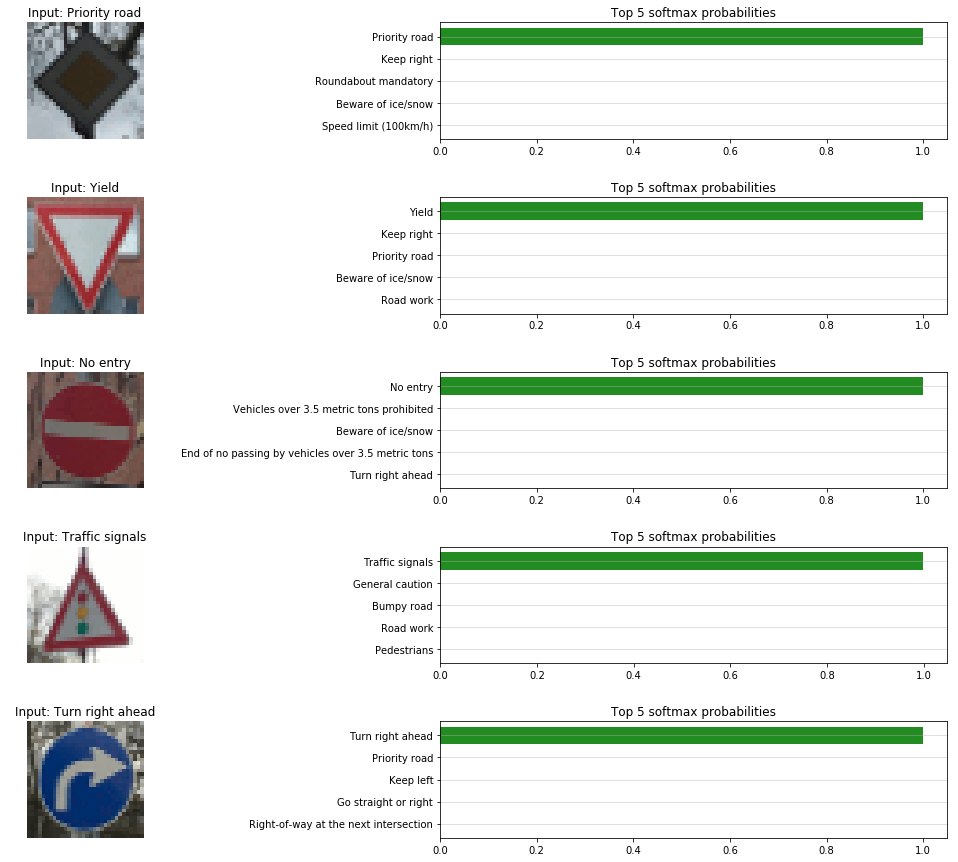

In [77]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 

# Reset the current graph
tf.reset_default_graph()

graph=tf.Graph()
with graph.as_default():        
    sess = tf.Session()
    with sess.as_default():
        imported_graph = tf.train.import_meta_graph('./lenet2.meta')
        imported_graph.restore(sess, "./lenet2")
    
        softmax = graph.get_operation_by_name("softmax").outputs[0]
        x = graph.get_operation_by_name("x").outputs[0]
        y = graph.get_operation_by_name("y").outputs[0]
        keep_prob = graph.get_operation_by_name("keep_prob").outputs[0]

        probabilities, cids = sess.run(tf.nn.top_k(softmax, k=5), feed_dict={x: pre_new_images, y: new_images_class, keep_prob: 1.0})
        
        # Show images and the corresponding top 5 softmax probabilities
        fig = plt.figure(figsize=(20,15))
        fig.subplots_adjust(hspace=0.5, wspace=0.2)
        for i in range(5):       
            # Plot input image
            subfig = fig.add_subplot(5, 2, i*2 + 1)
            subfig.axis('off')
            subfig.set_title("Input: " + sign_classes[new_images_class[i]])
            subfig.imshow(new_images[i])            
            
            # Plot top 5 softmax probabilities
            subfig = fig.add_subplot(5, 2, i*2 + 2)
            class_names = [sign_classes[cid] for cid in cids[i, ...]]
            y_pos = np.arange(len(class_names))
            subfig.barh(y_pos, probabilities[i][::-1], align='center', color='#228B22')
            subfig.set_yticks(y_pos)
            subfig.set_yticklabels(class_names[::-1])
            subfig.set_title('Top 5 softmax probabilities')
            subfig.grid(axis='y', alpha=0.5)
        plt.savefig('output_images/softmax.png', type="png", bbox_inches='tight')

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.